In [16]:
import pandas as pd
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt

In [68]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import re
from wordcloud import WordCloud, STOPWORDS
from matplotlib import rcParams


In [18]:
import warnings
warnings.filterwarnings('ignore')

# user.json

See older versions of the file to retrieve the code!

# CSV file from 'business.json'

In [19]:
# Reading in 'extacted_restaurants_from_business.csv'
rest_biz_csvTOpd = pd.read_csv('extracted_restaurants_from_business.csv')

In [20]:
# Business IDs for the restaurants
restaurant_id_list = rest_biz_csvTOpd.business_id.tolist()
restaurant_id_list[:5]

['QXAEGFB4oINsVuTFxEYKFQ',
 'gnKjwL_1w79qoiV3IC_xQQ',
 '1Dfx3zM-rW4n-31KeC8sJg',
 'fweCYi8FmbJXHCqLnwuk8w',
 'PZ-LZzSlhSe9utkQYU8pFg']

In [21]:
print('Number of restaurants in the original dataset:',len(restaurant_id_list))

Number of restaurants in the original dataset: 59371


# CSV file from 'review.json'

In [22]:
# Reading in 'extracted_restaurants_from_review.csv'
rest_review_csvTOpd = pd.read_csv('extracted_restaurants_from_review.csv')

In [23]:
# Rename column containing the old indices
rest_review_csvTOpd.rename(columns={"Unnamed: 0": "Index_From_review.JSON"}).head()

,Index_From_review.JSON,review_id,business_id,stars,text
0,3,yi0R0Ugj_xUx_Nek0-_Qig,ikCg8xy5JIg_NGPx-MSIDA,5.0,Went in for a lunch. Steak sandwich was delici...
1,5,fdiNeiN_hoCxCMy2wTRW9g,eU_713ec6fTGNO4BegRaww,4.0,I'll be the first to admit that I was not exci...
2,6,G7XHMxG0bx9oBJNECG4IFg,3fw2X5bZYeW9xCz_zGhOHg,3.0,Tracy dessert had a big name in Hong Kong and ...
3,7,8e9HxxLjjqc9ez5ezzN7iQ,zvO-PJCpNk4fgAVUnExYAA,1.0,This place has gone down hill. Clearly they h...
4,10,kbtscdyz6lvrtGjD1quQTg,8mIrX_LrOnAqWsB5JrOojQ,4.0,"Like walking back in time, every Saturday morn..."


# Modeling

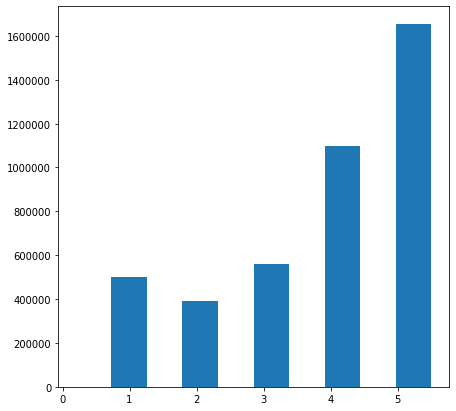

In [24]:
plt.figure(figsize=(7,7))
plt.hist(rest_review_csvTOpd.stars, range = (0.2,5.5), bins = 10)
plt.show()

In [25]:
# Random EDA
rest_review_length = len(rest_review_csvTOpd)
print("There are {} restaurant reviews.".format(rest_review_length))
testset = rest_review_csvTOpd[:1000]
category = testset.stars
testset.head()

There are 4201685 restaurant reviews.


,Unnamed: 0,review_id,business_id,stars,text
0,3,yi0R0Ugj_xUx_Nek0-_Qig,ikCg8xy5JIg_NGPx-MSIDA,5.0,Went in for a lunch. Steak sandwich was delici...
1,5,fdiNeiN_hoCxCMy2wTRW9g,eU_713ec6fTGNO4BegRaww,4.0,I'll be the first to admit that I was not exci...
2,6,G7XHMxG0bx9oBJNECG4IFg,3fw2X5bZYeW9xCz_zGhOHg,3.0,Tracy dessert had a big name in Hong Kong and ...
3,7,8e9HxxLjjqc9ez5ezzN7iQ,zvO-PJCpNk4fgAVUnExYAA,1.0,This place has gone down hill. Clearly they h...
4,10,kbtscdyz6lvrtGjD1quQTg,8mIrX_LrOnAqWsB5JrOojQ,4.0,"Like walking back in time, every Saturday morn..."


In [26]:
one_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 1.0]
two_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 2.0]
three_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 3.0]
four_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 4.0]
five_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 5.0]

In [27]:
# Figuring out what percentage of the "rest_review_csvTOpd" should be training data, and what percentage should be test data.
num_train_data = int(rest_review_length * 0.8)
print("For 80% of the data, there should be {} reviews.".format(num_train_data))

For 80% of the data, there should be 3361348 reviews.


In [28]:
# Train data has equal amounts of each rating.
train_data = pd.concat([one_star.text[:1600], two_star.text[:1600], three_star.text[:1600], four_star.text[:1600], five_star.text[:1600]])
train_labels = pd.concat([one_star.stars[:1600], one_star.stars[:1600], three_star.stars[:1600], five_star.stars[:1600], five_star.stars[:1600]])

test_data = pd.concat([one_star.text[1600:1700], two_star.text[1600:1700], three_star.text[1600:1700], four_star.text[1600:1700], five_star.text[1600:1700]])
test_labels = pd.concat([one_star.stars[1600:1700], one_star.stars[1600:1700], three_star.stars[1600:1700], five_star.stars[1600:1700], five_star.stars[1600:1700]])

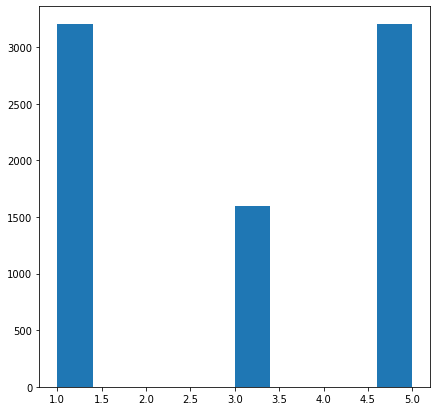

In [29]:
plt.figure(figsize=(7,7))
plt.hist(train_labels, range = (1,5), bins = 10)
plt.show()

In [38]:
# Fit CountVectorizer with your text data
vectorizer = CountVectorizer()
# train_data = testset.text.tolist()
vtrain = vectorizer.fit_transform(train_data)
vdev = vectorizer.transform(test_data)

In [39]:
# Train LogisticRegression Classifier
lr_classifier = LogisticRegression(C=0.09)
lr_classifier.fit(vtrain, train_labels)
train_predicted_labels = lr_classifier.predict(vdev)
f1_score = metrics.f1_score(test_labels, train_predicted_labels, average = 'weighted')
print(f1_score)

0.7645667436311591


In [40]:
lr_classifier.predict_proba(vdev)

array([[0.95321591, 0.01361652, 0.03316756],
       [0.72909956, 0.15708661, 0.11381383],
       [0.8697856 , 0.06072605, 0.06948835],
       ...,
       [0.13702692, 0.11199388, 0.7509792 ],
       [0.07445364, 0.02312043, 0.90242593],
       [0.10455203, 0.11123606, 0.78421191]])

# Sample Prediction

In [41]:
# Predict new sentence
test_sentence = "I hate this place"
test_sentence = [test_sentence]

In [42]:
new_test = vectorizer.transform(test_sentence)
lr_classifier.predict(new_test)
lr_classifier.predict_proba(new_test)

array([[0.47168233, 0.172166  , 0.35615168]])

# Predictions without the neutral data

In [33]:
# Throwing away the neutral data
NO3_train_data = pd.concat([one_star.text[:1600], two_star.text[:1600], four_star.text[:1600], five_star.text[:1600]])
NO3_train_labels = pd.concat([one_star.stars[:1600], one_star.stars[:1600], five_star.stars[:1600], five_star.stars[:1600]])

NO3_test_data = pd.concat([one_star.text[1600:1700], two_star.text[1600:1700], four_star.text[1600:1700], five_star.text[1600:1700]])
NO3_test_labels = pd.concat([one_star.stars[1600:1700], one_star.stars[1600:1700], five_star.stars[1600:1700], five_star.stars[1600:1700]])

In [34]:
# Fit CountVectorizer with your text data
vectorizer = CountVectorizer()
# train_data = testset.text.tolist()
v_NO3_train = vectorizer.fit_transform(NO3_train_data)
v_NO3_dev = vectorizer.transform(NO3_test_data)

In [35]:
# Train LogisticRegression Classifier
lr_classifier = LogisticRegression(C=0.08)
lr_classifier.fit(v_NO3_train, NO3_train_labels)
train_predicted_labels = lr_classifier.predict(v_NO3_dev)
f1_score = metrics.f1_score(NO3_test_labels, train_predicted_labels, average = 'weighted')
print(f1_score)

0.917474726635032


* So if we throw out the moderate data (the 3-star reviews), it is clear that there is a difference between positive and negative reviews.

# Word Cloud

## Word Cloud without Tfidf

In [104]:
stopwords = STOPWORDS

In [105]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=1000).generate(positive_reviews)

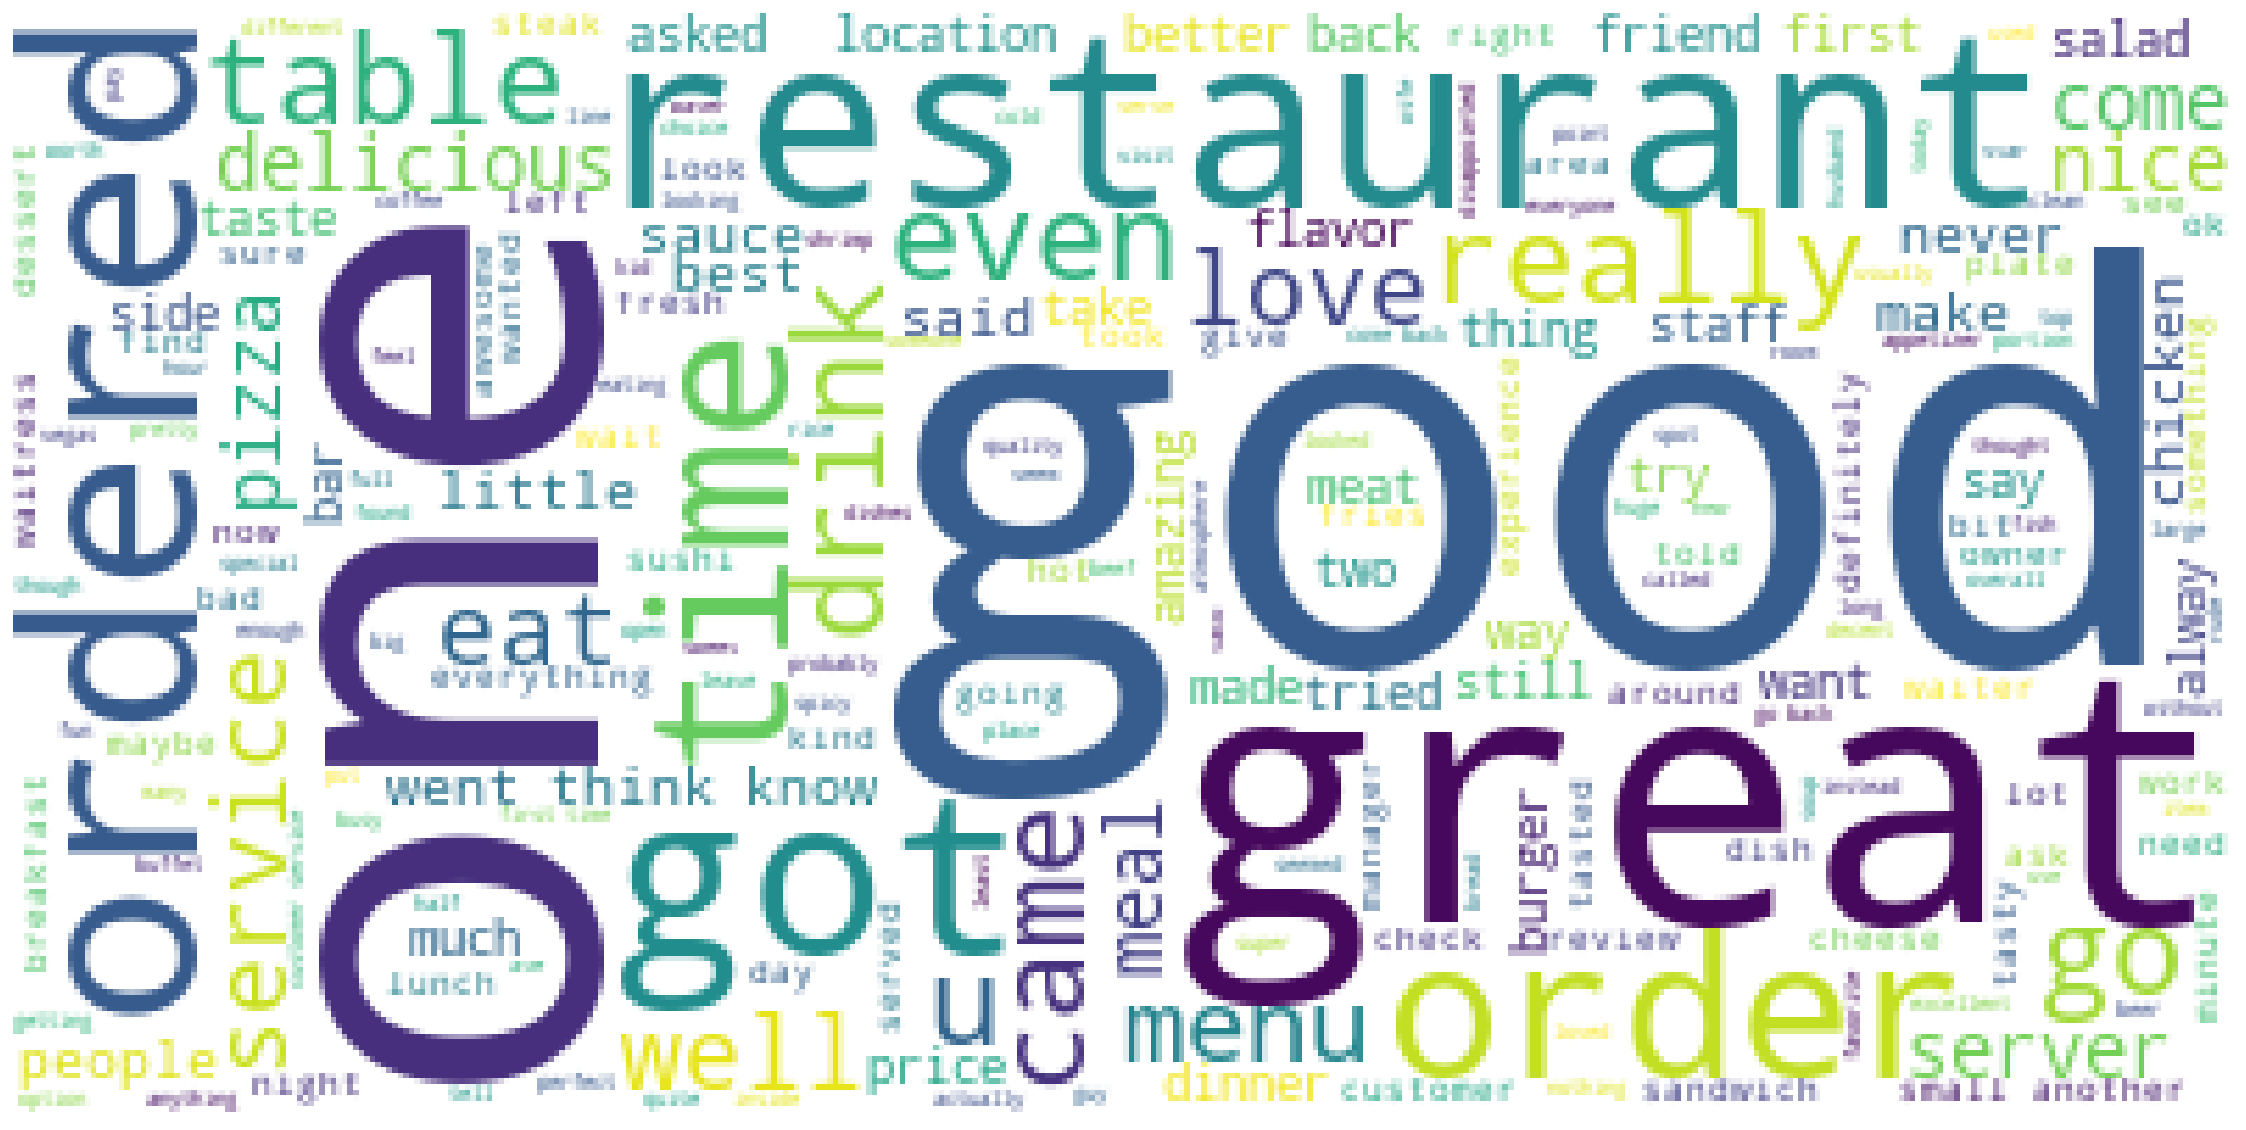

In [106]:
rcParams['figure.figsize'] = 40, 40
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Word Cloud with Tfidf

In [112]:
cloud_train_data = pd.concat([one_star.text[:1600], five_star.text[:1600]]).tolist()
cloud_train_labels = pd.concat([one_star.stars[:1600], five_star.stars[:1600]])
print(type(cloud_train_data))

<class 'list'>


In [95]:
# Positive Reviews Dataset
positive_reviews = " ".join(NO3_train_data).lower()
print(positive_reviews[:100])

this place has gone down hill.  clearly they have cut back on staff and food quality

many of the re


In [92]:
positive_list = five_star.text[1600:2000].tolist()

In [ ]:
vectorizer = TfidfVectorizer()
tfidf_vtrain = vectorizer.fit_transform(positive_list)

In [ ]:
# Negative Reviews Dataset
negative_reviews

In [66]:
# stopwords = STOPWORDS
# stopwords.add('will')

wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=1000).generate(cloud_test)

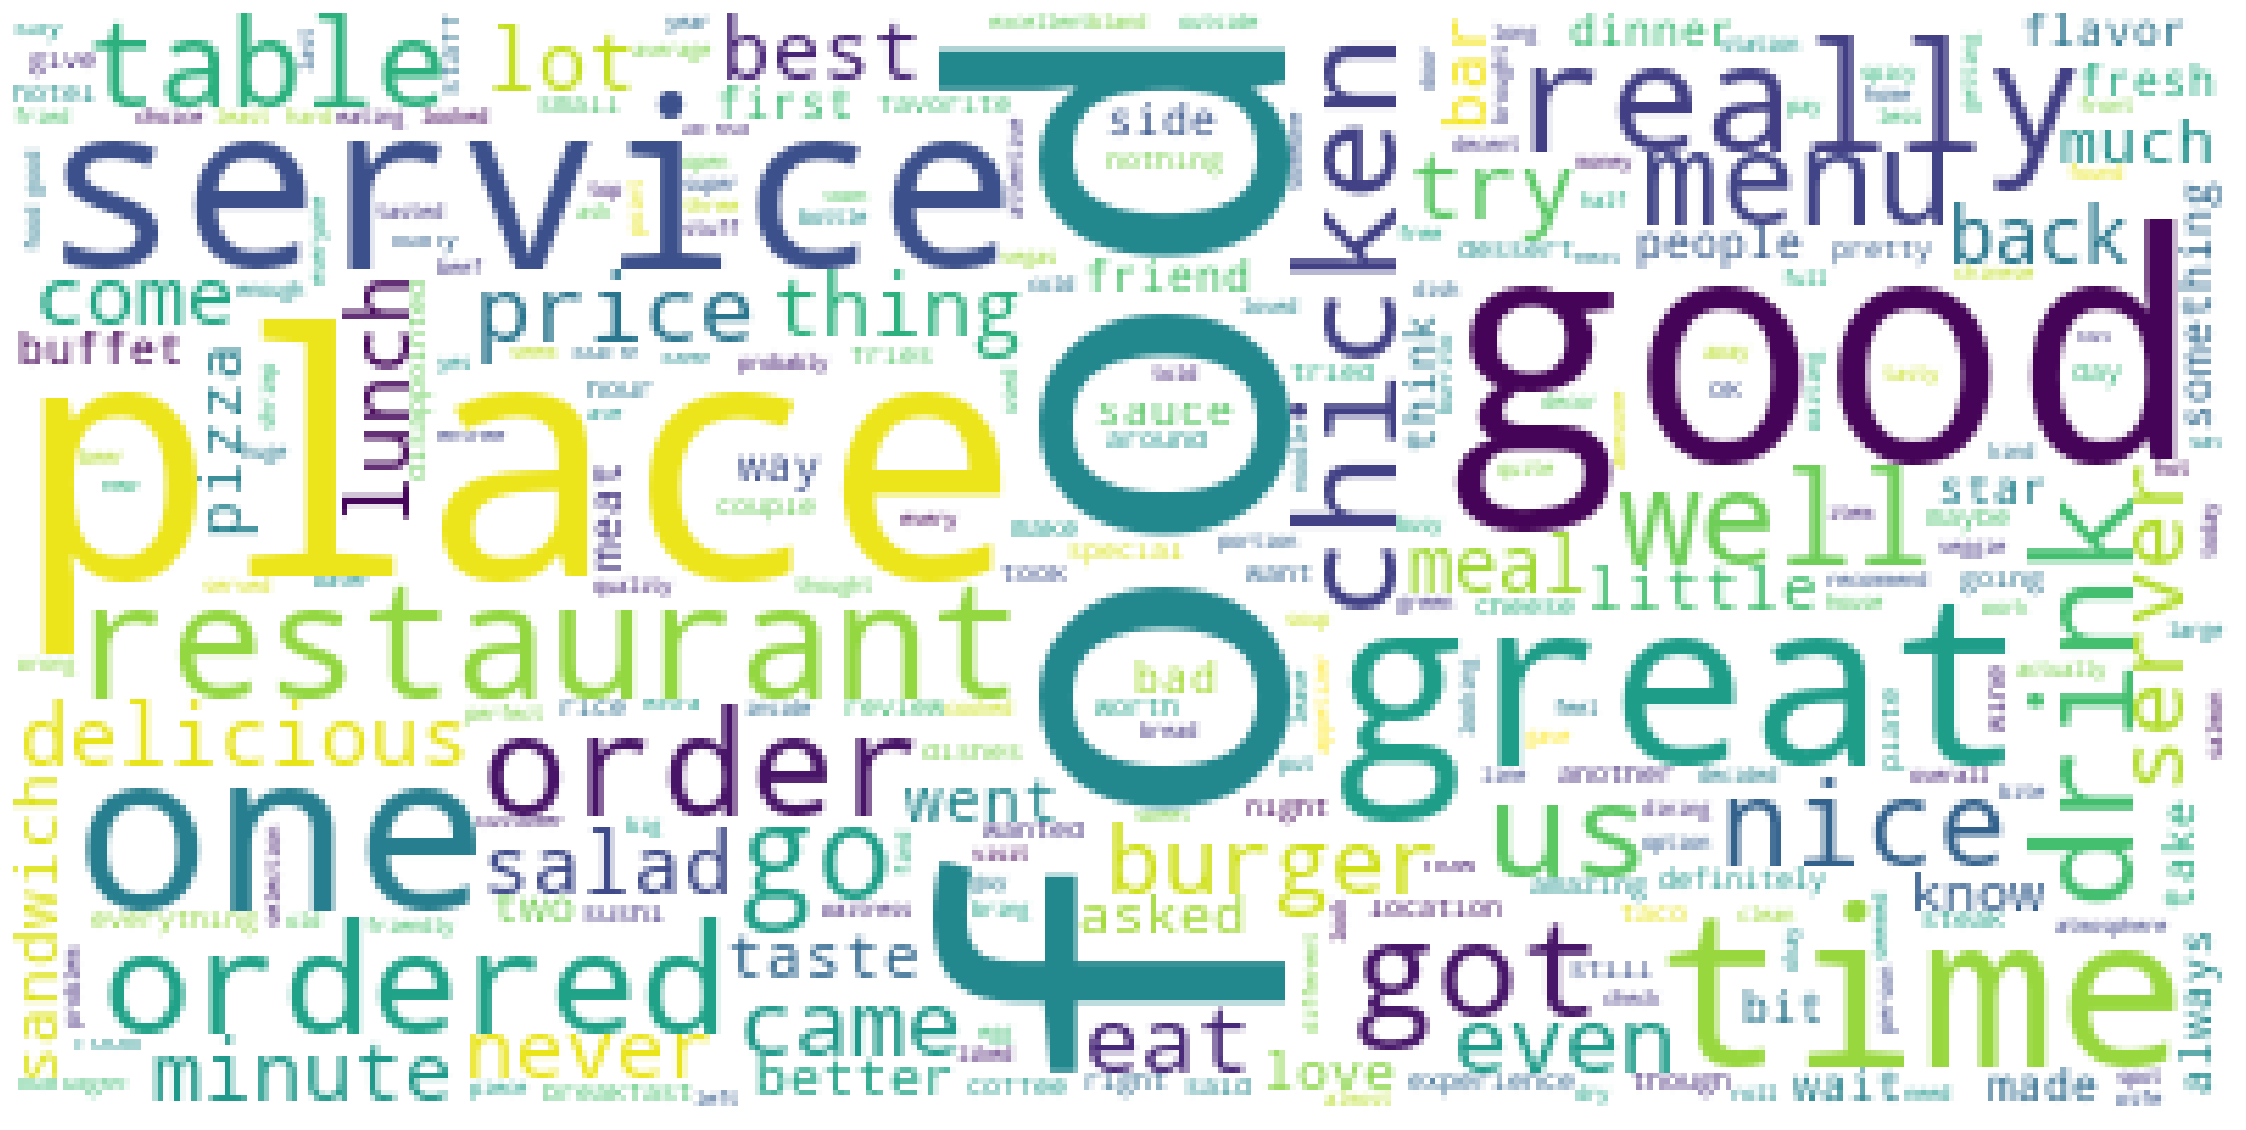

In [70]:
rcParams['figure.figsize'] = 40, 40
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

* Some positive words in the wordcloud for negative reviews may be an indicator of